# Manual Model Selection Playground

This notebook is intended as a playground to test out different models. We will prepare the data for training, 

In [1]:
# Correct working directory.
# This is necessary for imports because the notebook is not in the main folder of the project.
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

# Update the Python path to ensure imports are working correctly
import sys
sys.path.append(os.getcwd())

# Import dependencies
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, precision_score, recall_score, classification_report, multilabel_confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import time
import random
import wandb

from PIL import Image

from data.coral_condition_dataset import CoralConditionDataset, CoralImageProcessor, CoralReefDataset

# Random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

/datasets/_deepnote_work/coral_reef_monitoring


In [2]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sarakabariti (sarakabariti-code-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 1. Data Preparation

In [4]:
# Initialize Dataset & Processor
dataset = CoralConditionDataset(annotations_file="annotations_cleaned.csv")
processor = CoralImageProcessor(dataset.IMAGES_PATH)

# Get preprocessed data splits
(X_train, y_train), (X_val, y_val), (X_test, y_test) = dataset.split_dataset()
class_names = dataset.LABELSET_PATH['label_name'].tolist()

# Calculate class weights
class_weights_dict = dataset.calculate_class_weights(y_train)

print("\nClass weights for handling imbalance:")
for idx, weight in sorted(class_weights_dict.items()):
    print(f"{class_names[idx]}: {weight:.2f}")

# Convert to list in correct class order
class_weights = [class_weights_dict[i] for i in range(len(class_weights_dict))]



Class weights for handling imbalance:
Background: 2.44
Healthy coral: 0.15
Compromised coral: 0.38
Dead coral: 0.29
Rubble: 1.05
Competition: 0.89
Disease: 0.93
Predation: 3.62
Physical issues: 0.92


In [5]:
# Image transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),  # Converts PIL to tensor and normalizes to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Create datasets
train_dataset = CoralReefDataset(X_train, y_train, processor, train_transform)
val_dataset = CoralReefDataset(X_val, y_val, processor, val_transform)
test_dataset = CoralReefDataset(X_test, y_test, processor, val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

print(f"\nDataset sizes:")
print(f"Training: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")
print(f"Total: {len(train_dataset)+len(val_dataset)+len(test_dataset)} images")


Dataset sizes:
Training: 16767 images
Validation: 2396 images
Test: 4791 images
Total: 23954 images


## 2. Training Function

In [7]:
class CoralModelTrainer:
    def __init__(self, model, name, train_loader, val_loader, class_weights):
        self.model = model.to(device)
        self.name = name
        
        # Initialize W&B
        wandb.init(
            project="coral-reef-monitoring",
            name=f"{name}-run",
            config={
                "learning_rate": 1e-4,
                "batch_size": 32,
                "epochs": 5,
                "architecture": name,
                "class_weights": class_weights,
            }
        )
        
        # Track gradients and parameters
        wandb.watch(model, log="all", log_freq=100)
        
        # Loss and optimizer
        weights_tensor = torch.FloatTensor(class_weights).to(device)
        self.criterion = nn.BCEWithLogitsLoss(weight=weights_tensor)
        self.optimizer = optim.AdamW(model.parameters(), lr=1e-4)
        
    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        progress = tqdm(self.train_loader, desc=f"Training {self.name} Epoch {epoch+1}")
        
        for images, labels in progress:
            images, labels = images.to(device), labels.to(device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            progress.set_postfix(loss=loss.item())
            
            # Log batch loss to W&B
            wandb.log({"batch_train_loss": loss.item()})
        
        return running_loss / len(self.train_loader)
    
    def evaluate(self, loader):
        self.model.eval()
        all_preds, all_labels = [], []
        running_loss = 0.0
        
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                
                preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
                all_preds.extend(preds) # Store probabilities for ROC
                all_labels.extend(labels.cpu().numpy())
        
        y_true, y_pred = np.array(all_labels), (np.array(all_preds) > 0.5).astype(int)

        # Calculate metrics
        metrics = {
            "loss": running_loss / len(loader),
            "accuracy": accuracy_score(y_true, y_pred),
            "micro_f1": f1_score(y_true, y_pred, average="micro"),
            "macro_f1": f1_score(y_true, y_pred, average="macro"),
            "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
            "hamming_loss": hamming_loss(y_true, y_pred),
            "precision_micro": precision_score(y_true, y_pred, average="micro"),
            "recall_micro": recall_score(y_true, y_pred, average="micro"),
        }
        
        # Per-class metrics
        cls_report = classification_report(
            y_true, y_pred, 
            target_names=class_names,
            output_dict=True,
            zero_division=0
        )
        
        for cls in class_names:
            metrics.update({
                f"precision_{cls}": cls_report[cls]["precision"],
                f"recall_{cls}": cls_report[cls]["recall"],
                f"f1_{cls}": cls_report[cls]["f1-score"],
                f"support_{cls}": cls_report[cls]["support"],
            })
        
        return metrics
    
    def train(self, epochs=5):
        history = []
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
                wandb.log({"batch_train_loss": loss.item()})
            
            # Validation phase
            val_metrics = self.evaluate(val_loader)
            
            # Log to W&B
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss / len(train_loader),
                **{f"val_{k}": v for k, v in val_metrics.items()},
            })
            
            # Append metrics after each epoch
            history.append({
                "epoch": epoch,
                "train_loss": train_loss / len(train_loader),
                **val_metrics,
            })
            print(f"Epoch {epoch+1}: "
                 f"Train Loss={train_loss/len(train_loader):.4f}, "
                 f"Val Loss={val_metrics['loss']:.4f}, "
                 f"Val F1={val_metrics['micro_f1']:.4f}")
        
        wandb.finish()
        return pd.DataFrame(history)


## 3. Initialize Model

In [8]:
# Initialize models with pretrained weights
models_dict = {
    "ResNet50": models.resnet50(weights=class_weights),
}

# Modify final layers
for name, model in models_dict.items():
    if "resnet" in name.lower():
        model.fc = nn.Linear(model.fc.in_features, 9)
    elif "vit" in name.lower():
        model.heads.head = nn.Linear(model.heads.head.in_features, 9)
    print(f"Initialized {name}")

/root/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Initialized ResNet50


## 4. Model Training

In [9]:
# Train each model
import time
from datetime import datetime

results = {}
for name, model in models_dict.items():
    print(f"\nTraining {name}:")
    trainer = CoralModelTrainer(model, name, train_loader, val_loader, class_weights)
    history_df = trainer.train(epochs=5)
    results[name] = history_df

    # Save model weights
    torch.save(model.state_dict(), f'{name}_model.pth')
    
    # Save training history (file per training run)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    history_df = history_df.reset_index().rename(columns={"index": "epoch"})
    history_df.to_csv(f'{name}_training_history_{timestamp}.csv', index=False)
    
    # Plot metrics
    plt.figure(figsize=(15, 10))
    
    # Loss plot
    plt.subplot(2, 2, 1)
    plt.plot(history_df['epoch'], history_df['train_loss'], 'b-', label='Train Loss')
    plt.plot(history_df['epoch'], history_df['val_loss'], 'r-', label='Val Loss')
    plt.title("Loss Curves")
    plt.legend()
    
    # F1 scores plot
    plt.subplot(2, 2, 2)
    plt.plot(history_df['epoch'], history_df['val_micro_f1'], 'g-', label='Micro F1')
    plt.plot(history_df['epoch'], history_df['val_macro_f1'], 'm-', label='Macro F1')
    plt.title("F1 Trends")
    plt.legend()
    
    # Per-class F1 plot
    plt.subplot(2, 2, 3)
    for cls in ['Dead coral', 'Healthy coral', 'Disease']:
        plt.plot(history_df['epoch'], history_df[f'val_f1_{cls}'], label=cls)
    plt.title("Per-Class F1")
    plt.legend()
    
    # Hamming loss plot
    plt.subplot(2, 2, 4)
    plt.plot(history_df['epoch'], history_df['val_hamming_loss'], 'k-')
    plt.title("Hamming Loss")
    
    plt.suptitle(f"{name} Training Report", y=1.02)
    plt.tight_layout()
    plt.show()


Training ResNet50:


Epoch 1:   0%|          | 0/524 [00:03<?, ?it/s]


KeyboardInterrupt: 

## 5. Model Evaluation

In [ ]:
def evaluate_model(model, test_loader, class_names):
    """Comprehensive model evaluation with W&B logging"""
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Store probabilities and thresholded predictions
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_probs = np.array(all_probs)
    
    # Calculate metrics
    metrics = {
        "test_loss": 0,  # Placeholder - actual loss requires criterion
        "test_accuracy": accuracy_score(y_true, y_pred),
        "test_micro_f1": f1_score(y_true, y_pred, average="micro"),
        "test_macro_f1": f1_score(y_true, y_pred, average="macro"),
        "test_weighted_f1": f1_score(y_true, y_pred, average="weighted"),
        "test_hamming_loss": hamming_loss(y_true, y_pred),
    }
    
    # Per-class metrics
    cls_report = classification_report(
        y_true, y_pred, 
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    
    # Confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    # W&B Logging
    wandb_logs = {
        **metrics,
        "confusion_matrices": wandb.plot.confusion_matrix(
            y_true=y_true,
            preds=y_pred,
            class_names=class_names
        ),
        "roc_curve": wandb.plot.roc_curve(y_true, y_probs, class_names),
    }
    
    # Add per-class metrics
    for cls in class_names:
        wandb_logs.update({
            f"test_precision_{cls}": cls_report[cls]["precision"],
            f"test_recall_{cls}": cls_report[cls]["recall"],
            f"test_f1_{cls}": cls_report[cls]["f1-score"],
        })
    
    wandb.log(wandb_logs)
    
    # Print summary
    print("\n" + "="*50)
    print(f"{model.__class__.__name__} Test Results")
    print("="*50)
    print(f"Micro F1: {metrics['test_micro_f1']:.4f}")
    print(f"Macro F1: {metrics['test_macro_f1']:.4f}")
    print(f"Hamming Loss: {metrics['test_hamming_loss']:.4f}")
    
    # Plot confusion matrices
    plt.figure(figsize=(15, 12))
    for i, (cls, matrix) in enumerate(zip(class_names, mcm)):
        plt.subplot(3, 3, i+1)
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", 
                   xticklabels=["Negative", "Positive"],
                   yticklabels=["Negative", "Positive"])
        plt.title(f"{cls}\nF1={cls_report[cls]['f1-score']:.2f}")
    plt.tight_layout()
    plt.show()
    
    return metrics

In [136]:
# Run evaluation on all trained models
test_metrics = {}
for name, model in models_dict.items():
    print(f"\nEvaluating {name}...")
    model.load_state_dict(torch.load(f"{name}_model.pth"))  # Load best weights
    test_metrics[name] = evaluate_model(model, test_loader, class_names)


 ResNet50 Test Results:
                   precision    recall  f1-score   support

       Background       0.05      0.21      0.08       218
    Healthy coral       0.00      0.00      0.00      3465
Compromised coral       0.28      0.97      0.44      1370
       Dead coral       0.39      0.98      0.56      1837
           Rubble       0.08      0.13      0.10       502
      Competition       0.11      0.48      0.18       565
          Disease       0.08      0.01      0.01       584
        Predation       0.00      0.00      0.00       139
  Physical issues       0.12      0.92      0.21       582

        micro avg       0.22      0.44      0.29      9262
        macro avg       0.12      0.41      0.17      9262
     weighted avg       0.14      0.44      0.21      9262
      samples avg       0.22      0.39      0.27      9262



,Class,F1 Score
0,Background,0.077246
1,Healthy coral,0.000000
2,Compromised coral,0.439444
3,Dead coral,0.557550
4,Rubble,0.096421
5,Competition,0.179554
6,Disease,0.012618
7,Predation,0.000000
8,Physical issues,0.207433


## 6. Compare Results

,Exact Match,Micro F1,Macro F1,Hamming Loss
ResNet50,0.0,0.294796,0.174474,0.449709


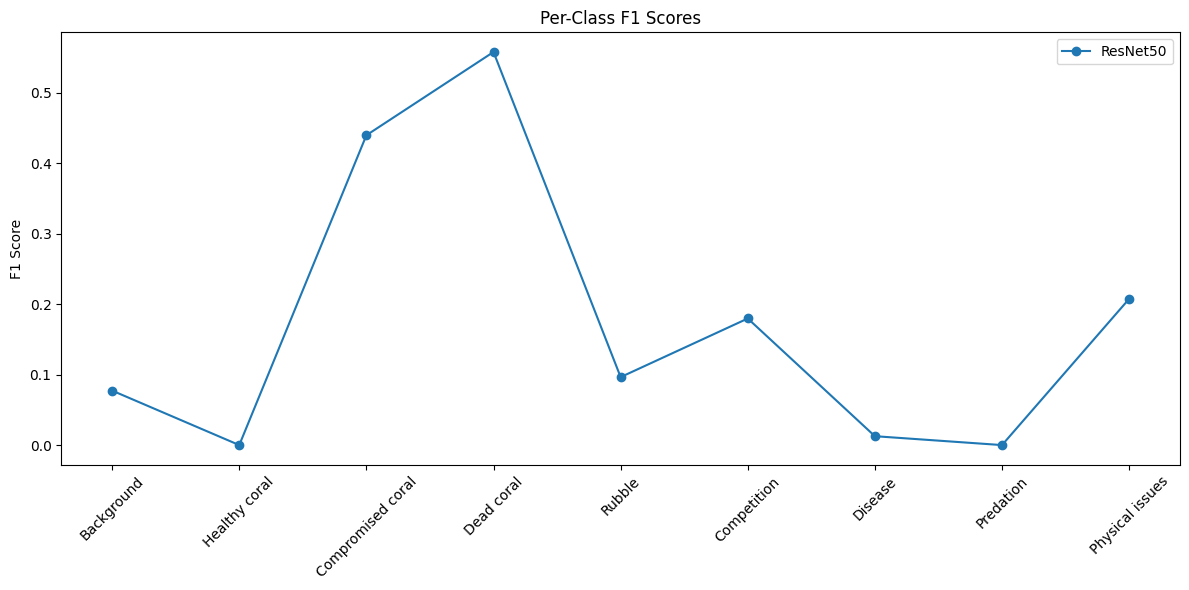

In [137]:
def compare_results(test_metrics, class_names):
    """Generate comprehensive model comparison with visualizations"""
    
    # Aggregate Metrics Table
    metrics_df = pd.DataFrame.from_dict(test_metrics, orient='index')
    
    # Select and rename key metrics
    comparison_table = metrics_df[[
        'test_accuracy', 'test_micro_f1', 'test_macro_f1', 'test_hamming_loss'
    ]]
    comparison_table.columns = [
        'Exact Match Ratio', 'Micro F1', 'Macro F1', 'Hamming Loss'
    ]
    
    # Add performance delta column
    best_micro = comparison_table['Micro F1'].max()
    comparison_table['% of Best F1'] = (
        comparison_table['Micro F1'] / best_micro * 100
    ).round(1)
    
    # Style the table
    styled_table = comparison_table.style\
        .background_gradient(cmap='Blues', subset=['Micro F1', 'Macro F1'])\
        .background_gradient(cmap='Reds_r', subset=['Hamming Loss'])\
        .format({
            'Exact Match Ratio': '{:.2%}',
            'Micro F1': '{:.3f}',
            'Macro F1': '{:.3f}',
            'Hamming Loss': '{:.3f}',
            '% of Best F1': '{:.1f}%'
        })
    
    display(styled_table.set_caption("Model Performance Comparison"))
    
    # Per-Class Performance Radar Chart
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Prepare data for radar chart
    angles = np.linspace(0, 2*np.pi, len(class_names), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    for model_name, metrics in test_metrics.items():
        f1_scores = [metrics[f'test_f1_{cls}'] for cls in class_names]
        f1_scores += f1_scores[:1]  # Close the loop
        ax.plot(angles, f1_scores, 'o-', label=model_name)
        ax.fill(angles, f1_scores, alpha=0.1)
    
    # Format radar chart
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), class_names)
    ax.set_rlabel_position(180)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=8)
    plt.ylim(0, 1)
    plt.title("Per-Class F1 Scores (Radar Chart)", pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()
    
    # Critical Class Performance Highlight
    critical_classes = ['Disease', 'Predation', 'Healthy coral']
    plt.figure(figsize=(10, 5))
    for cls in critical_classes:
        cls_scores = [test_metrics[model][f'test_f1_{cls}'] for model in test_metrics]
        plt.bar(np.arange(len(cls_scores)) + 0.2 * critical_classes.index(cls), 
                cls_scores, width=0.2, label=cls)
    
    plt.xticks(np.arange(len(test_metrics)), list(test_metrics.keys()))
    plt.ylabel("F1 Score")
    plt.title("Performance on Critical Coral Conditions")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)
    plt.show()
    
    # Export comparison data
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    comparison_table.to_csv(f"model_comparison_{timestamp}.csv")
    print(f"Comparison saved to model_comparison_{timestamp}.csv")

# Usage (after running evaluate_model() on all models)
compare_results(test_metrics, class_names)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1bbe612-0141-4225-8340-26ebcaa65485' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>